In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from itertools import combinations
from math import prod, log
from sklearn.linear_model import LinearRegression
import pymc as pm
import pymc.math as math
import pytensor.tensor as pt
import arviz as az
import graphviz

In [8]:
iSubject = 1
trial_per_block = 50
nCondition = 6
nTrial = 9600
nBlock = 32

def to_block_prob(input_string):
    remove_elements = ['\n', '[', ']']
    for element in remove_elements:
        input_string =  input_string.replace(element, '')
    input_string = input_string.split()
    output_arr =  [float(string) for string in input_string]
    return np.array(output_arr)

def to_para_set(input_string):
    if type(input_string) == str:
        remove_elements = ['[', ']']
        for element in remove_elements:
            input_string =  input_string.replace(element, '')
        input_string = input_string.split()
        para_set =  np.array([float(string) for string in input_string])
    else:
        para_set = input_string
    feature_arr = []
    n_combine = [1,2,3,4,5,6]
    index = [0,1,2,3,4,5]

    for n in n_combine:
        combine = list(combinations(index, n))
        for current_combine in combine:
            feature_arr.append(prod(para_set[list(current_combine)]))
    return np.array(feature_arr)

def compute_curve(X_train, coef_matrix):
    ones_column = np.ones((X_train.shape[0], 1))
    X_train = np.append(X_train, 1)
    return (X_train @ coef_matrix.T).reshape((nCondition,nBlock))

In [9]:
search_grid = pd.read_csv('search grid 6_6.csv', header = None).values
X_train, y_train = [], []
for i in range(len(search_grid)):
    X_train.append(to_para_set(search_grid[i][1]))
    y_train.append(to_block_prob(search_grid[i][2]))
X_train = np.array(X_train)
y_train = np.array(y_train)

In [10]:
coef_matrix = np.array(())
for block in range(y_train.shape[1]):
    y_subtrain = y_train[:,block]
    model = LinearRegression()
    model.fit(X_train, y_subtrain)
    w = np.append(model.coef_,model.intercept_)
    coef_matrix = np.append(coef_matrix, w)
coef_matrix = coef_matrix.reshape(y_train.shape[1],w.shape[0])
coef_tensor_matrix = pt.as_tensor_variable(coef_matrix)

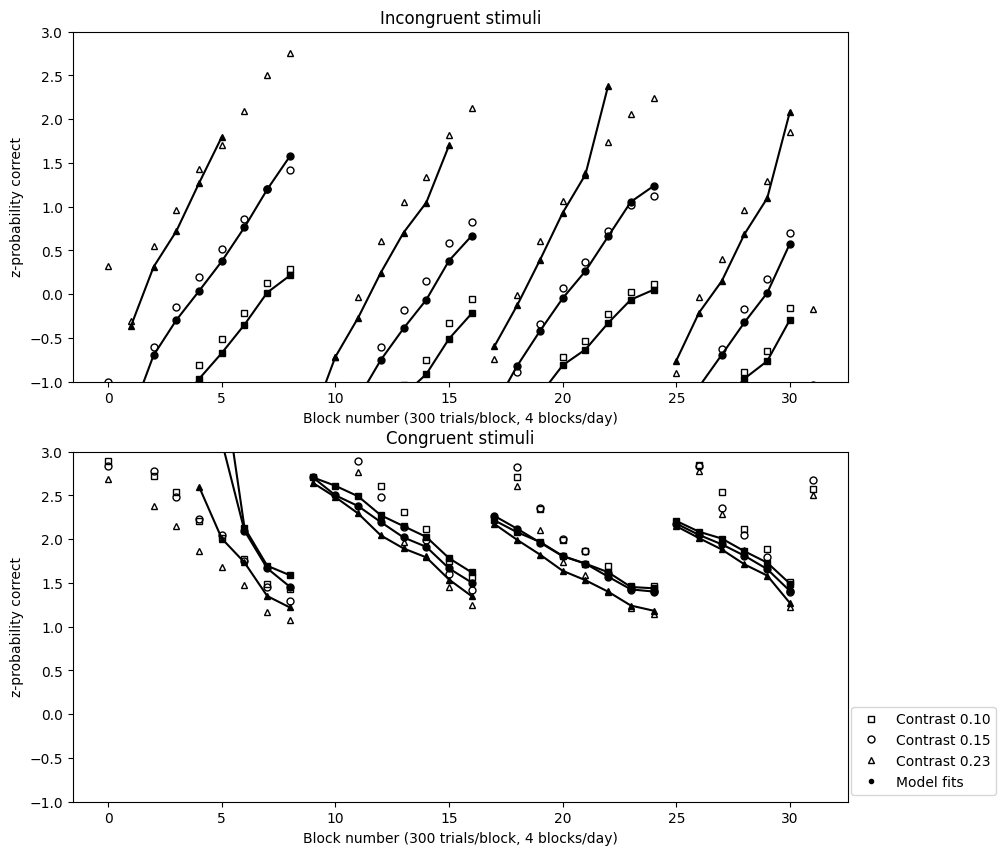

In [19]:
# test set
test_num = 41000
block_prob_simu = compute_curve(X_train[test_num], coef_matrix)
block_prob_true = y_train[test_num].reshape((nCondition,nBlock))

title={0:'Incongruent stimuli', 1: 'Congruent stimuli'}
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
axes=[ax1,ax2]
for i in [0,1]:
    low_model, low_true = block_prob_simu[i*3],  block_prob_true[i*3]
    middle_model, middle_true = block_prob_simu[i*3+1],  block_prob_true[i*3+1]
    high_model, high_true = block_prob_simu[i*3+2],  block_prob_true[i*3+2]
    
    z_low_model,z_middle_model,z_high_model= stats.norm.ppf(low_model), stats.norm.ppf(middle_model), stats.norm.ppf(high_model)
    start=[1,9,17,25,31]
    for j in range(4):
        low_model_fit, normal_model_fit, high_model_fit=z_low_model[start[j]:start[j+1]],z_middle_model[start[j]:start[j+1]],z_high_model[start[j]:start[j+1]]
        axes[i].plot(np.arange(start[j],start[j+1]), low_model_fit, color='black', marker='s', markersize=5)
        axes[i].plot(np.arange(start[j],start[j+1]), normal_model_fit, color='black', marker='o', markersize=5)
        axes[i].plot(np.arange(start[j],start[j+1]), high_model_fit, color='black', marker='^', markersize=5)
       
    z_low_true,z_middle_true,z_high_true= stats.norm.ppf(low_true), stats.norm.ppf(middle_true), stats.norm.ppf(high_true)
    
    axes[i].plot(z_low_true, marker='s',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.10')
    axes[i].plot(z_middle_true, marker='o',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.15')
    axes[i].plot(z_high_true, marker='^', color='black',linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.23')
    
    axes[i].set_ylabel('z-probability correct')
    axes[i].set_xlabel('Block number (300 trials/block, 4 blocks/day)')
    axes[i].set_title(title.get(i))
    axes[i].set_ylim(-1,3)
    
legend_handles = [plt.Line2D([],[],marker='s',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.10'),
                  plt.Line2D([],[],marker='o',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.15'),
                  plt.Line2D([],[],marker='^',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.23'),
                  plt.Line2D([], [], color='black', marker='o',markersize=3, linestyle='None', label='Model fits'),]
plt.legend(handles=legend_handles, loc='lower right',bbox_to_anchor=(1.2, 0))
# plt.savefig(f'results/congruent and incongruent/Subject_{iSubject}',bbox_inches='tight')
plt.show()

In [20]:

df = pd.read_csv('Data_withfeedback.csv')[iSubject * nTrial : (iSubject + 1) * nTrial]
correct = df['Correct'].values
contrast = df['Contrast'].values
congruent = df['Congruent'].values

li = np.intersect1d(np.where(contrast==0.10),np.where(congruent==0))
mi = np.intersect1d(np.where(contrast==0.15),np.where(congruent==0))
hi = np.intersect1d(np.where(contrast==0.23),np.where(congruent==0))
lc = np.intersect1d(np.where(contrast==0.10),np.where(congruent==1))
mc = np.intersect1d(np.where(contrast==0.15),np.where(congruent==1))
hc = np.intersect1d(np.where(contrast==0.23),np.where(congruent==1))

learning_curve = correct[np.stack([li, mi, hi, lc, mc, hc])].reshape(nCondition,nBlock,trial_per_block).sum(axis=2)

combine_arr = []
n_combine = [2,3,4,5,6]
index = [0,1,2,3,4,5]
for n in n_combine:
    combine = list(combinations(index, n))
    for current_combine in combine:
            combine_arr.append(list(current_combine))

In [29]:
BIP = pm.Model()
low = 1e-4
lower=[log(low), log(low), log(low),log(low), log(low), log(low)]
upper=[log(0.005), log(5), log(3), log(0.5), log(0.5), log(0.5)]

'''
lr_range = [0.0010,0.0015,0.0020,0.0025]
bias_range = [1.5,2.0,2.5,3.0]
gamma_range = [0.4,0.8,1.2,1.6]
noise_d_range = [0.12,0.20,0.28,0.36]
noise_r_range = [0.05,0.10,0.15,0.20]
w_init_range = [0.15,0.20,0.25,0.30]
'''
with BIP:
    para = pm.Uniform('para', upper=upper, lower=lower)
    exp_para = math.exp(para)
    for i_combine in range(len(combine_arr)):
        exp_para = math.concatenate([exp_para, [math.prod(exp_para[combine_arr[i_combine]])]], axis= 0)
    exp_para = math.concatenate([exp_para, [math.ones_like(1)]])
    curve = pt.clip((exp_para @ coef_matrix.T).reshape((nCondition,nBlock)), 0.001, 0.999)
    n_block_correct = pm.Binomial('n_block_correct', p = curve, n = trial_per_block, observed = learning_curve)

In [25]:
with BIP:
    #idata = pm.sample(draws = 3000, tune = 3000)
    approx=pm.fit(n=200000,method='advi')
    idata=approx.sample(10000)
    print(az.summary(idata, round_to = 6))

Finished [100%]: Average Loss = 606.18
arviz - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


             mean        sd    hdi_3%   hdi_97%  mcse_mean   mcse_sd  \
para[0] -7.266969  0.093252 -7.431776 -7.082828   0.000933  0.000660   
para[1]  0.736149  0.026974  0.684252  0.784874   0.000270  0.000191   
para[2] -0.101402  0.055570 -0.204927  0.002726   0.000551  0.000394   
para[3] -6.603674  1.604032 -8.977262 -3.572728   0.016055  0.011353   
para[4] -6.026846  2.025335 -9.055575 -2.369718   0.020413  0.014435   
para[5] -2.716293  0.095652 -2.889761 -2.528360   0.000959  0.000678   

             ess_bulk     ess_tail  r_hat  
para[0]   9984.991223  9328.709856    NaN  
para[1]   9968.423048  9797.071585    NaN  
para[2]  10166.394880  9436.490347    NaN  
para[3]  10009.395867  9448.748920    NaN  
para[4]   9801.043131  9659.393786    NaN  
para[5]   9946.617946  9797.599543    NaN  


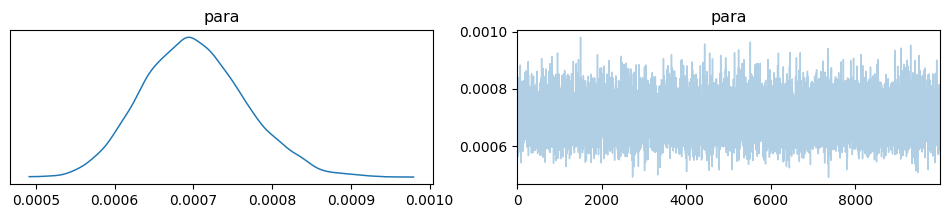

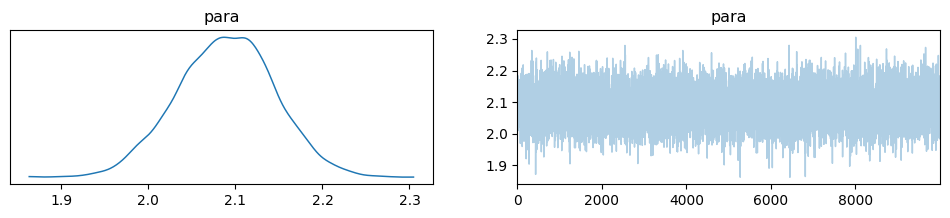

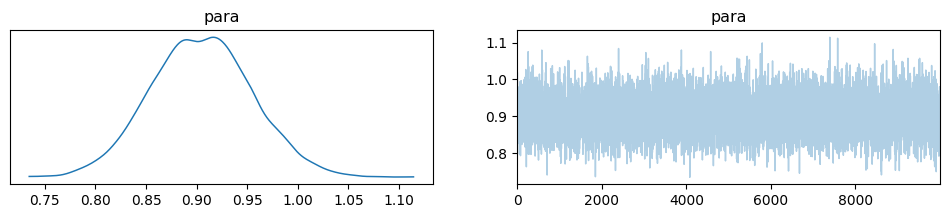

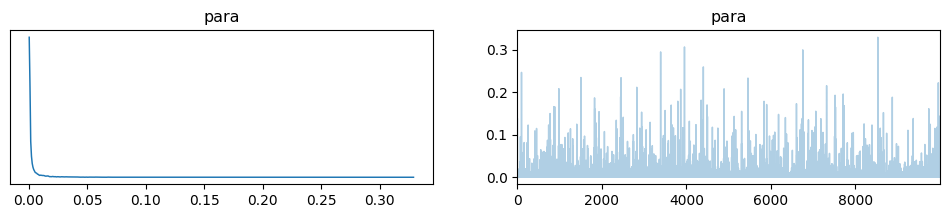

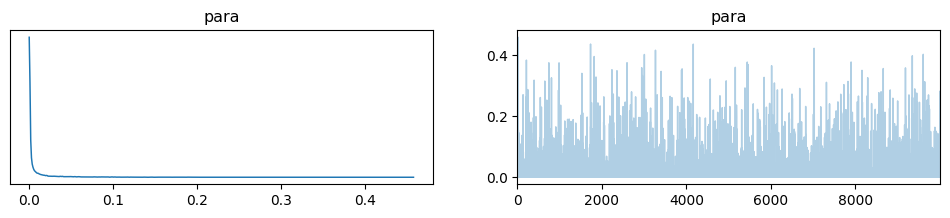

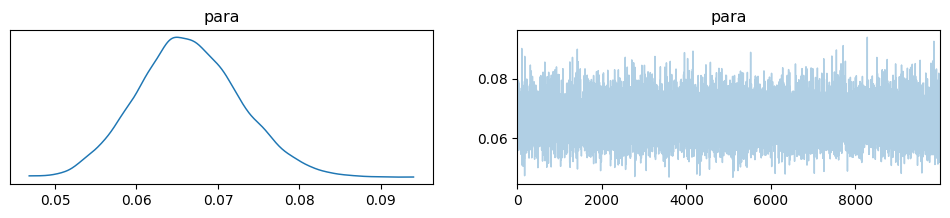

In [26]:
para = np.exp(idata.posterior["para"])
for i in range(para.shape[-1]):
    az.plot_trace(para[..., i])

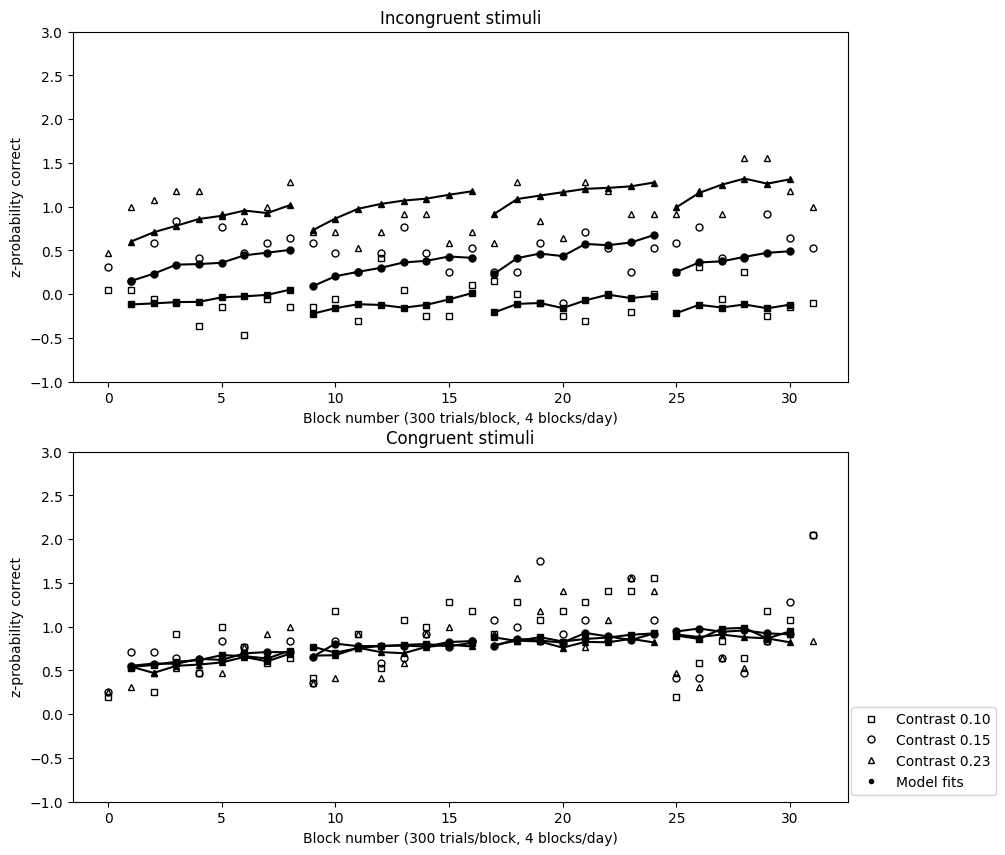

In [23]:
block_prob_true = learning_curve/trial_per_block
block_prob_simu = compute_curve(to_para_set(np.exp(np.array([-7.2617, 0.737, -0.096, -6.611, -5.97, -2.71]))), coef_matrix)

title={0:'Incongruent stimuli', 1: 'Congruent stimuli'}
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))
axes=[ax1,ax2]
for i in [0,1]:
    low_model, low_true = block_prob_simu[i*3],  block_prob_true[i*3]
    middle_model, middle_true = block_prob_simu[i*3+1],  block_prob_true[i*3+1]
    high_model, high_true = block_prob_simu[i*3+2],  block_prob_true[i*3+2]
    
    z_low_model,z_middle_model,z_high_model= stats.norm.ppf(low_model), stats.norm.ppf(middle_model), stats.norm.ppf(high_model)
    start=[1,9,17,25,31]
    for j in range(4):
        low_model_fit, normal_model_fit, high_model_fit=z_low_model[start[j]:start[j+1]],z_middle_model[start[j]:start[j+1]],z_high_model[start[j]:start[j+1]]
        axes[i].plot(np.arange(start[j],start[j+1]), low_model_fit, color='black', marker='s', markersize=5)
        axes[i].plot(np.arange(start[j],start[j+1]), normal_model_fit, color='black', marker='o', markersize=5)
        axes[i].plot(np.arange(start[j],start[j+1]), high_model_fit, color='black', marker='^', markersize=5)
       
    z_low_true,z_middle_true,z_high_true= stats.norm.ppf(low_true), stats.norm.ppf(middle_true), stats.norm.ppf(high_true)
    
    axes[i].plot(z_low_true, marker='s',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.10')
    axes[i].plot(z_middle_true, marker='o',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.15')
    axes[i].plot(z_high_true, marker='^', color='black',linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.23')
    
    axes[i].set_ylabel('z-probability correct')
    axes[i].set_xlabel('Block number (300 trials/block, 4 blocks/day)')
    axes[i].set_title(title.get(i))
    axes[i].set_ylim(-1,3)
    
legend_handles = [plt.Line2D([],[],marker='s',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.10'),
                  plt.Line2D([],[],marker='o',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.15'),
                  plt.Line2D([],[],marker='^',color='black', linestyle='',markerfacecolor='none',markeredgewidth=1,markersize=5, label='Contrast 0.23'),
                  plt.Line2D([], [], color='black', marker='o',markersize=3, linestyle='None', label='Model fits'),]
plt.legend(handles=legend_handles, loc='lower right',bbox_to_anchor=(1.2, 0))
# plt.savefig(f'results/congruent and incongruent/Subject_{iSubject}',bbox_inches='tight')
plt.show()

